# future_emis
## Purpose: input IAM projections of future emissions under different policy scenarios
- Data from NGFS

### 01/29/24, Erica Simon

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import copy

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

## Import historical emissions dataset 
`hist_emis`

In [116]:
hist_emis = pd.read_csv('~/inputs/all_scaled_1750-2022.csv')

# remove 'Emissions|' from variable name
for i in range(len(hist_emis.variable.values)): 
    hist_emis.variable.values[i] = hist_emis.variable.values[i][10:]

# rename to match FaIR spceies
hist_emis.loc[hist_emis.variable == 'CO2|AFOLU', 'variable'] = 'CO2 AFOLU'
hist_emis.loc[hist_emis.variable == 'CO2|Energy and Industrial Processes', 'variable'] = 'CO2 FFI'

hist_emis.head()

,model,scenario,region,variable,unit,1750,1751,1752,1753,1754,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Historical,GCP+CEDS+PRIMAP+GFED,World,BC,Mt BC/yr,2.096766,2.071972,2.067178,2.070382,2.098586,...,7.842259,7.934828,7.926371,7.568060,7.562319,7.459095,7.781842,6.525021,6.871947,6.701702
1,Historical,GCP+CEDS+PRIMAP+GFED,World,C2F6,kt C2F6/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.003458,1.035565,0.933936,0.979945,0.996980,0.996764,1.062577,1.106550,1.160588,1.167145
2,Historical,GCP+CEDS+PRIMAP+GFED,World,C3F8,kt C3F8/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.314138,0.323186,0.304124,0.319107,0.324656,0.324586,0.346019,0.360340,0.377938,0.380074
3,Historical,GCP+CEDS+PRIMAP+GFED,World,C4F10,kt C4F10/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.070672,0.070641,0.067024,0.070327,0.071550,0.071536,0.076260,0.079417,0.083292,0.083759
4,Historical,GCP+CEDS+PRIMAP+GFED,World,C5F12,kt C5F12/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035588,0.031141,0.030030,0.031513,0.032065,0.032062,0.034184,0.035603,0.037338,0.037545


## Import & clean future emissions dataset
`proj_emis`

In [187]:
proj_emis = pd.read_csv('~/inputs/NGFS_GCAM.csv')

# remove final row- does not contain emission data
proj_emis = proj_emis.drop(index=175)

# remove 'Emissions|' from variable name
for i in range(len(proj_emis.Variable.values)): 
    proj_emis.Variable.values[i] = proj_emis.Variable.values[i][10:]
    
# rename to match FaIR spceies
proj_emis.loc[proj_emis.Variable == 'CO2|AFOLU', 'Variable'] = 'CO2 AFOLU'
proj_emis.loc[proj_emis.Variable == 'CO2|Energy and Industrial Processes', 'Variable'] = 'CO2 FFI'
proj_emis.loc[proj_emis.Variable == 'HFC|HFC125', 'Variable'] = 'HFC-125'
proj_emis.loc[proj_emis.Variable == 'HFC|HFC134a', 'Variable'] = 'HFC-134a'
proj_emis.loc[proj_emis.Variable == 'HFC|HFC227ea', 'Variable'] = 'HFC-227ea'
proj_emis.loc[proj_emis.Variable == 'HFC|HFC143a', 'Variable'] = 'HFC-143a'
proj_emis.loc[proj_emis.Variable == 'HFC|HFC23', 'Variable'] = 'HFC-23'
proj_emis.loc[proj_emis.Variable == 'HFC|HFC245fa', 'Variable'] = 'HFC-245fa'
proj_emis.loc[proj_emis.Variable == 'HFC|HFC32', 'Variable'] = 'HFC-32'

# get rid of species not included in hist dataset (F-Gases, HFC, PFC)
proj_emis = proj_emis[~proj_emis['Variable'].isin(['F-Gases', 'HFC', 'PFC'])]

In [188]:
proj_emis

,Model,Scenario,Region,Variable,Unit,2020,2025,2030,2035,2040,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,GCAM 6.0 NGFS,Below 2?C (version: 1),World,CO2,Mt CO2/yr,36039.003300,35347.288950,29549.148040,24301.610030,19048.636340,...,5244.729484,1698.010095,-1141.522320,-3165.056547,-5085.914059,-5192.409086,-5246.878344,-5262.514988,-5250.299249,-5217.607977
1,GCAM 6.0 NGFS,Below 2?C (version: 1),World,CO2 FFI,Mt CO2/yr,34691.057390,34523.660090,29248.538080,24524.444290,19795.296310,...,7039.374659,3491.937626,652.009829,-1371.427622,-3292.545043,-3398.849190,-3453.294842,-3468.979036,-3456.824053,-3424.187145
2,GCAM 6.0 NGFS,Below 2?C (version: 1),World,HFC-23,kt HFC23/yr,12.312555,14.563458,15.478346,16.102191,16.489296,...,15.425561,15.078069,14.785010,14.426263,13.869847,13.989513,13.950013,13.737708,13.465602,13.163498
3,GCAM 6.0 NGFS,Below 2?C (version: 1),World,HFC-143a,kt HFC143a/yr,71.835179,81.638302,89.908816,81.712190,76.592792,...,35.915003,28.684093,25.974026,23.207285,19.796926,21.634965,22.561935,22.555586,22.003674,21.273143
4,GCAM 6.0 NGFS,Below 2?C (version: 1),World,NH3,Mt NH3/yr,58.157863,61.589137,63.617577,65.931894,67.960164,...,71.530074,72.008721,72.639366,72.608240,72.267727,73.890453,75.010516,75.615545,75.854738,75.859863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,GCAM 6.0 NGFS,Net Zero 2050 (version: 1),World,HFC-125,kt HFC125/yr,66.072361,74.183041,74.557529,69.000827,64.055691,...,22.223263,18.582567,19.955286,20.213265,19.453467,18.170362,16.825187,15.592566,14.874667,14.207107
171,GCAM 6.0 NGFS,Net Zero 2050 (version: 1),World,HFC-227ea,kt HFC227ea/yr,3.546452,3.630557,4.214670,4.246061,4.287294,...,4.239639,3.861122,3.142045,2.724106,2.515596,2.147839,1.779646,1.548309,1.193944,0.701181
172,GCAM 6.0 NGFS,Net Zero 2050 (version: 1),World,VOC,Mt VOC/yr,180.567805,167.531696,150.401517,138.448622,126.910179,...,102.817618,104.188355,102.735775,103.306346,104.490329,105.734267,106.614704,107.655720,108.776030,109.786103
173,GCAM 6.0 NGFS,Net Zero 2050 (version: 1),World,C2F6,kt C2F6/yr,1.374271,1.411329,1.165709,1.107670,1.082879,...,1.041456,1.053314,1.067640,1.065870,1.047676,1.018710,0.985592,0.951364,0.917401,0.888361


In [189]:
a = hist_emis['variable'].unique()
b = proj_emis['Variable'].unique()

print('strings in hist but not proj:')
print(np.setdiff1d(a, b))

print('\nstrings in proj but not hist:')
print(np.setdiff1d(b, a))

strings in hist but not proj:
['C3F8' 'C4F10' 'C5F12' 'C6F14' 'C7F16' 'C8F18' 'CCl4' 'CFC-11' 'CFC-113'
 'CFC-114' 'CFC-115' 'CFC-12' 'CH2Cl2' 'CH3Br' 'CH3CCl3' 'CH3Cl' 'CHCl3'
 'HCFC-141b' 'HCFC-142b' 'HCFC-22' 'HFC-152a' 'HFC-236fa' 'HFC-365mfc'
 'HFC-4310mee' 'Halon-1211' 'Halon-1301' 'Halon-2402' 'NF3' 'SO2F2'
 'c-C4F8']

strings in proj but not hist:
['CO2']


## Plot projected vs. historical CH4 emissions

In [141]:
ch4_proj = proj_emis.loc[proj_emis.Variable == 'CH4'].loc[proj_emis.Scenario == 'Current Policies (version: 1)']
ch4_proj = ch4_proj.values[0][5:].astype(float)

In [142]:
ch4_proj

array([320.8162241, 332.3504848, 349.4731017, 370.7043309, 383.7314283,
       396.5458579, 406.4101421, 413.584382 , 416.1188587, 418.3506344,
       417.2221213, 415.408043 , 410.5150104, 406.2395599, 401.7712512,
       395.3983755, 388.6285407])

Projections are in 5-year timesteps, so we need to interpolate over the interval

In [143]:
yrs = np.arange(2020, 2101, 5)
all_yrs = np.arange(2020, 2101)

In [144]:
ch4_proj_interp = np.interp(all_yrs, yrs, ch4_proj)

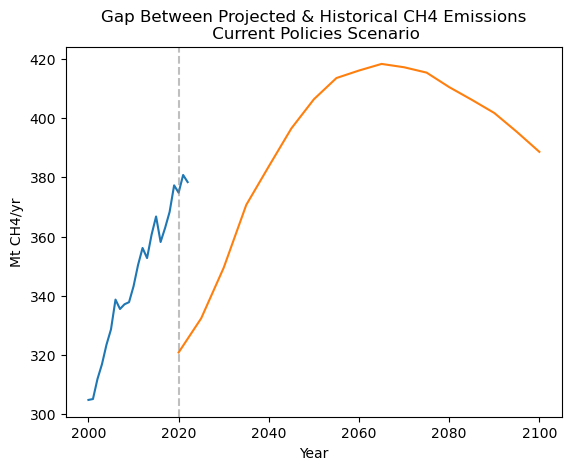

In [167]:
plt.plot(np.arange(2000, 2023), hist_emis.loc[hist_emis.variable == 'CH4'].values[0][255:])
plt.plot(np.arange(2020, 2101), ch4_proj_interp)
plt.axvline(2020, linestyle='--', color='grey', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Mt CH4/yr')
plt.title('Gap Between Projected & Historical CH4 Emissions\n Current Policies Scenario')
plt.show()